In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cPickle as pickle
import copy
import neo
import elephant as el
import elephant.conversion as conv
from quantities import Hz, s, ms
%matplotlib inline

/home/joele119/anaconda2/envs/data_env/lib/python2.7/site-packages/h5py/__init__.py:36: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._conv import register_converters as _register_converters
/home/joele119/anaconda2/envs/data_env/lib/python2.7/site-packages/h5py/__init__.py:45: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import h5a, h5d, h5ds, h5f, h5fd, h5g, h5r, h5s, h5t, h5p, h5z
/home/joele119/anaconda2/envs/data_env/lib/python2.7/site-packages/h5py/_hl/group.py:22: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .. import h5g, h5i, h5o, h5r, h5t, h5l, h5p
/home/joele119/anaconda2/envs/data_env/lib/python2.7/site-packages/sklearn/utils/__init__.py:9: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .murmurhash import murmurhash3_32
/home/joele119

In [2]:
def raster_plot(spk):
    for i, spiketrain in enumerate(spk):
        t = spiketrain.rescale(ms)
        plt.plot(t,i*np.ones_like(t),'k.',markersize=2)
    plt.axis('tight')
    # plt.xlim(500000,510000)
    plt.xlabel('Time(ms)',fontsize=16)
    plt.ylabel('Spike Train Index',fontsize=16)
    plt.gca().tick_params(axis='both', which='major', labelsize=14)
    plt.show()

# special loader function to bring nested structs into Python
# thanks to StackOverflow!
import scipy.io as spio
import numpy as np


def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def compare_rasters(spk,idx1,idx2):
    spk1=[]
    spk2=[]
    for spiketrain in spk:
        temp1=copy.deepcopy(spiketrain[(spiketrain.times>exp1start[idx1])&(spiketrain.times<exp1stop[idx1])])
        spk1.append(temp1)
        temp2=copy.deepcopy(spiketrain[(spiketrain.times>exp1start[idx2])&(spiketrain.times<exp1stop[idx2])])
        spk2.append(temp2)
    fig=plt.figure(figsize=(15,8))
    ax1=fig.add_subplot(121)
    for i, spiketrain in enumerate(spk1):
        t = spiketrain.rescale(ms)
        ax1.plot(t,i*np.ones_like(t),'k.',markersize=2)
    #plt.axis('tight')
    # plt.xlim(500000,510000)
    ax1.set_xlabel('Time(ms)',fontsize=16)
    ax1.set_ylabel('Spike Train Index',fontsize=16)
    #ax1.gca().tick_params(axis='both', which='major', labelsize=14)
    
    ax2=fig.add_subplot(122)
    for i, spiketrain in enumerate(spk2):
        t = spiketrain.rescale(ms)
        ax2.plot(t,i*np.ones_like(t),'k.',markersize=2)
   # plt.axis('tight')
    # plt.xlim(500000,510000)
    ax2.set_xlabel('Time(ms)',fontsize=16)
    ax2.set_ylabel('Spike Train Index',fontsize=16)
    
    #plt.gca().tick_params(axis='both', which='major', labelsize=14)
    
    plt.show()

In [3]:
Fs = 30000.

clu_f = np.load('./frontal/spike_clusters.npy')

ss_f = np.load('./frontal/spike_times.npy')

st_f = ss_f/Fs

spkTemps_f = np.load('./frontal/spike_templates.npy')

amps_f = np.load('./frontal/amplitudes.npy')

amps_f

array([[18.51144409],
       [12.93832397],
       [47.23517227],
       ...,
       [23.7265625 ],
       [31.41118622],
       [18.56385803]])

In [4]:
cid_g_f = pd.read_csv('./frontal/cluster_groups.csv',sep='\t')

noise=cid_g_f[cid_g_f['group']=='noise']

clu_f=pd.DataFrame(clu_f)
clu_f.columns = ['clusters']
st_f_clean=st_f[~clu_f.isin(noise['cluster_id'].tolist())]

st_f_clean=pd.DataFrame(st_f_clean)
st_f_clean.columns = ['spike times']

noise_clu=~clu_f.isin(noise['cluster_id'].tolist())
clu_f_clean=clu_f[noise_clu]
clu_f_clean=pd.DataFrame(clu_f_clean)
clu_f_clean.columns = ['clusters']
clu_f_clean.dropna(inplace=True)
#clu_f_clean.isnull().sum()

clu_f_clean.reset_index(drop=True,inplace=True)

df = clu_f_clean
df['spike times']=st_f_clean

df['clusters'].unique().shape

(822,)

In [5]:
cgs=df['clusters'].unique()

spk=[]
for unit in cgs:
    train=df['spike times'][df.clusters==unit].values
    spk.append(train)

temp=[]
for unit in spk:
    train = neo.SpikeTrain(times=unit,units='sec',t_start=0.0,t_stop=5050.0)
    temp.append(train)
    
spk=temp

Quick example of a raster plot

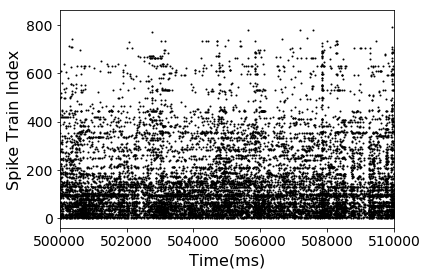

In [6]:
for i, spiketrain in enumerate(spk):
    t = spiketrain.rescale(ms)
    plt.plot(t,i*np.ones_like(t),'k.',markersize=2)
plt.axis('tight')
plt.xlim(500000,510000)
plt.xlabel('Time(ms)',fontsize=16)
plt.ylabel('Spike Train Index',fontsize=16)
plt.gca().tick_params(axis='both', which='major', labelsize=14)
plt.show()

Now let's look at mean activity across time (averaging across neurons)

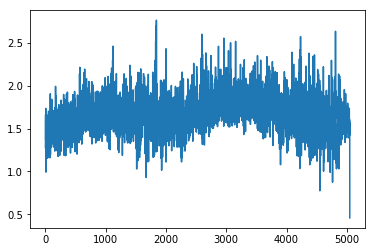

In [7]:
binsize=1*s
spk_binned = conv.BinnedSpikeTrain(spk,binsize=binsize,t_start=0*s).to_array()

mean_spikes = np.mean(spk_binned,0)

plt.plot(mean_spikes)

Now let's look at the histogram of number of spikes per neuron

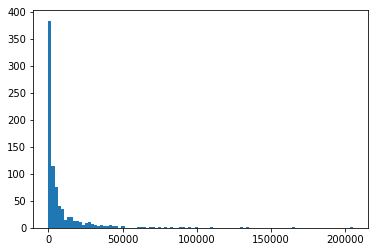

In [8]:
total_spk = np.sum(spk_binned,-1)
# total_spk.shape

_=plt.hist(total_spk,bins=100)

Now let's look at the activity of a single neuron

In [9]:
neuron_ix = 200
neuron = spk_binned[neuron_ix]

unique,counts=np.unique(neuron,return_counts=True)

In [10]:
print unique
print counts

[0 1 2 3 5]
[3715 1101  204   29    1]


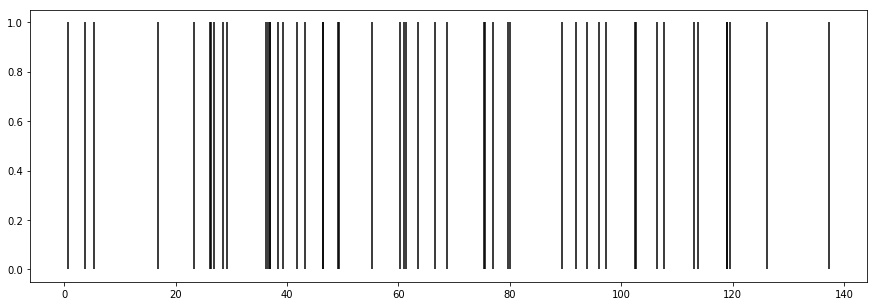

In [11]:
fig,ax=plt.subplots(figsize=(15,5))
ax.vlines(spk[neuron_ix][:50],0,1)

Let's load the experimental protocols into Python

In [12]:
exp1_info=loadmat('experiment1stimInfo.mat')

exp1_info.keys()

['Protocol',
 'stimStarts',
 '__globals__',
 '__header__',
 'stimStops',
 'stimIDs',
 '__version__']

In [13]:
exp2_info=loadmat('experiment2stimInfo.mat')

exp3_info=loadmat('experiment3stimInfo.mat')

Now let's divide up the spike trains into the 4 different experimental stages, and then further into a window for each stimulus

In [14]:
N=exp1_info['Protocol']['npfilestimuli']*exp1_info['Protocol']['nrepeats']
exp1start=exp1_info['stimStarts']
exp1stop=exp1_info['stimStops']

In [15]:
## This should only be run when making a new dissimilarity file
# dist_list=[]
# import elephant.spike_train_dissimilarity as dissim

# for i in range(N):
#     print i
#     temp_spks=[]
#     for spiketrain in spk:
#         temp=copy.deepcopy(spiketrain[(spiketrain.times>exp1start[i])&(spiketrain.times<exp1stop[i])])
#         temp_spks.append(temp)
#     dist_list.append(dissim.van_rossum_dist(temp_spks,sort=False))

# with open('spkdist1_VR_f.pkl','wb') as output:
    # pickle.dump(dist_list,output,pickle.HIGHEST_PROTOCOL)

Here we can compare any two stimuli responses - in particular, we want to compare responses among the same stimuli. Should look further into measures of 

In [16]:
np.where(exp1_info['stimIDs']==6)[0]

array([  0,  20,  26,  40,  56,  75,  83, 100, 114, 117])

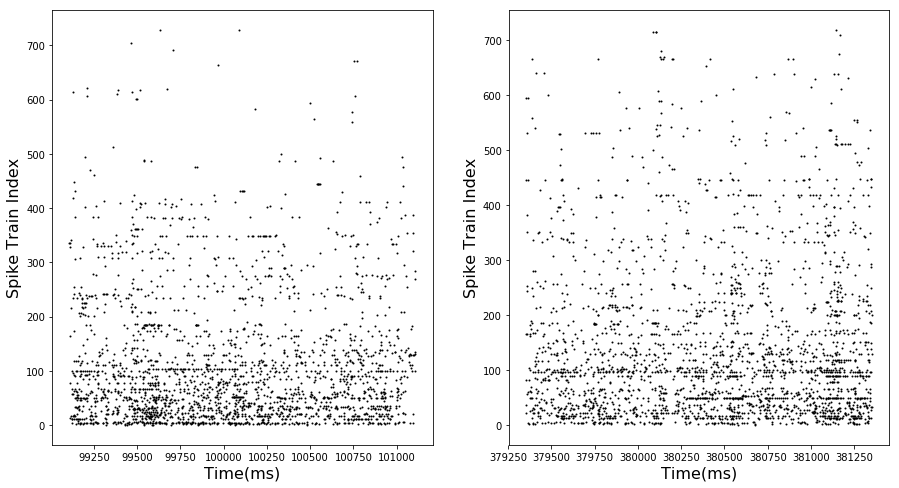

In [27]:
# functionality only for experiment 1 currently!
compare_rasters(spk,0,100)

In [18]:
# with open('spkdist1_VR_f.pkl','rb') as input:
#     dist_list=pickle.load(input)

# from scipy.cluster import hierarchy
# a=dist_list[0]
# z=hierarchy.linkage(a[np.tril_indices(a.shape[0],k=-1)],'average')

# plt.figure(figsize=(15,10))
# dn = hierarchy.dendrogram(z)
    

In [19]:
# from scipy.cluster import hierarchy
# a=dist_list[1]
# z=hierarchy.linkage(a[np.tril_indices(a.shape[0],k=-1)],'average')

# plt.figure(figsize=(18,10))
# dn = hierarchy.dendrogram(z)

In [20]:
spk_binned = conv.BinnedSpikeTrain(spk,binsize=1*ms,t_start=0*s).to_sparse_bool_array()


In [26]:
spk_binned

<822x5050000 sparse matrix of type '<type 'numpy.bool_'>'
	with 6932702 stored elements in Compressed Sparse Row format>

In [38]:
frame=1
ix1=int(np.floor(exp1start[frame]*1000))
ix2=int(np.ceil(exp1stop[frame]*1000))

In [42]:
spk_binned[:,ix1:ix2]

<822x2001 sparse matrix of type '<type 'numpy.bool_'>'
	with 2616 stored elements in Compressed Sparse Row format>

#### Finding features in frames

Here, I will be starting to find features in each of these frames and subjecting them to various ML algorithms to see if any of them have any predictive power.
These initial features may include (list to be expanded):
* binned spike times
* interspike statistics
* spike counts
* spike rates over different windows
* ~~spike concurrencies~~ (maybe later though)
* rate concurrencies

Maybe we'll just start there.

In [135]:
import elephant.statistics as stat

def find_frame(dataframe,framenum=1):
    ix1=int(np.floor(exp1start[framenum]*1000))
    ix2=int(np.ceil(exp1stop[framenum]*1000))
    df=dataframe[:,ix1:ix2]
    return df

def bin_frame(dataframe,framenum=1):
    ix1=int(np.floor(exp1start[framenum]*1000))
    ix2=int(np.ceil(exp1stop[framenum]*1000))
    df=conv.BinnedSpikeTrain(spk,binsize=1*ms,t_start=ix1*ms,t_stop=ix2*ms).to_bool_array()
    return df

def add_inst_rate(dataframe_spk,dataframe,framenum=1):
    ix1=int(np.floor(exp1start[framenum]*1000))
    ix2=int(np.ceil(exp1stop[framenum]*1000))
    ratedf=stat.instantaneous_rate(dataframe_spk,1*ms,t_start=ix1*ms,t_stop=ix2*ms)
    array=np.empty((822,ix2-ix1))
    for i,rate in enumerate(ratedf):
        array[i,:]=ratedf[i].as_array()
       


In [87]:
ana=stat.instantaneous_rate(spk[1],1*ms,t_start=ix1*ms,t_stop=ix2*ms)

In [130]:
ana.as_array()

array([[7.14225117],
       [7.14425477],
       [7.14625708],
       ...,
       [7.47302793],
       [7.47126627],
       [7.46950308]])

In [133]:
stat.isi(spk[1])

array([0.0129    , 0.0314    , 0.07956667, ..., 0.1895    , 0.08096667,
       0.0302    ]) * s